# Voice Classification

### Voice Data Set

This database was created to identify a voice as male or female, based upon acoustic properties of the voice and speech. The dataset consists of 3800 recorded voice samples. The voice samples are pre-processed by acoustic analysis in R using the seewave and tuneR packages.

The following acoustic properties of each voice are measured and included within the CSV:

<ul>
<li><strong>meanfreq</strong>: mean frequency (in kHz)</li>
<li><strong>sd</strong>: standard deviation of frequency</li>
<li><strong>median</strong>: median frequency (in kHz)</li>
<li><strong>Q25</strong>: first quantile (in kHz)</li>
<li><strong>Q75</strong>: third quantile (in kHz)</li>
<li><strong>IQR</strong>: interquantile range (in kHz)</li>
<li><strong>skew</strong>: skewness (see note in specprop description)</li>
<li><strong>kurt</strong>: kurtosis (see note in specprop description)</li>
<li><strong>sp.ent</strong>: spectral entropy</li>
<li><strong>sfm</strong>: spectral flatness</li>
<li><strong>mode</strong>: mode frequency</li>
<li><strong>centroid</strong>: frequency centroid (see specprop)</li>
<li><strong>peakf</strong>: peak frequency (frequency with highest energy)</li>
<li><strong>meanfun</strong>: average of fundamental frequency measured across acoustic signal</li>
<li><strong>minfun</strong>: minimum fundamental frequency measured across acoustic signal</li>
<li><strong>maxfun</strong>: maximum fundamental frequency measured across acoustic signal</li>
<li><strong>meandom</strong>: average of dominant frequency measured across acoustic signal</li>
<li><strong>mindom</strong>: minimum of dominant frequency measured across acoustic signal</li>
<li><strong>maxdom</strong>: maximum of dominant frequency measured across acoustic signal</li>
<li><strong>dfrange</strong>: range of dominant frequency measured across acoustic signal</li>
<li><strong>modindx</strong>: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range</li>
<li><strong>label</strong>: male or female</li>
</ul>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

In [3]:
df = pd.read_csv("voice-classification.csv")

In [4]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [5]:
df.shape

(3168, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
meanfreq,3168.0,0.180907,0.029918,0.039363,0.163662,0.184838,0.199146,0.251124
sd,3168.0,0.057126,0.016652,0.018363,0.041954,0.059155,0.067020,0.115273
median,3168.0,0.185621,0.036360,0.010975,0.169593,0.190032,0.210618,0.261224
Q25,3168.0,0.140456,0.048680,0.000229,0.111087,0.140286,0.175939,0.247347
Q75,3168.0,0.224765,0.023639,0.042946,0.208747,0.225684,0.243660,0.273469
IQR,3168.0,0.084309,0.042783,0.014558,0.042560,0.094280,0.114175,0.252225
skew,3168.0,3.140168,4.240529,0.141735,1.649569,2.197101,2.931694,34.725453
kurt,3168.0,36.568461,134.928661,2.068455,5.669547,8.318463,13.648905,1309.612887
sp.ent,3168.0,0.895127,0.044980,0.738651,0.861811,0.901767,0.928713,0.981997
sfm,3168.0,0.408216,0.177521,0.036876,0.258041,0.396335,0.533676,0.842936


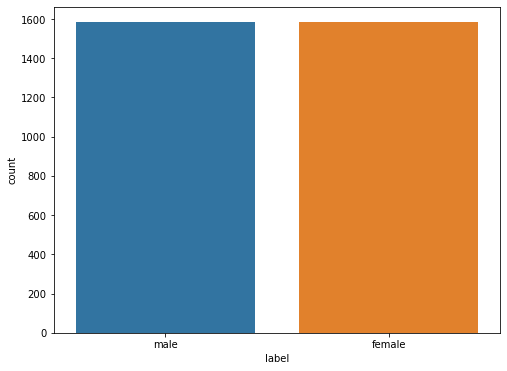

In [9]:
plt.figure(figsize= (8,6))

sns.countplot(data= df, x= "label")

plt.show()

In [ ]:
# No class Imbalance.

In [16]:
# Changing "label" to Numeric.

df["label"] = df["label"].map({"male":0,"female":1})

In [17]:
df["label"].value_counts()

0    1584
1    1584
Name: label, dtype: int64

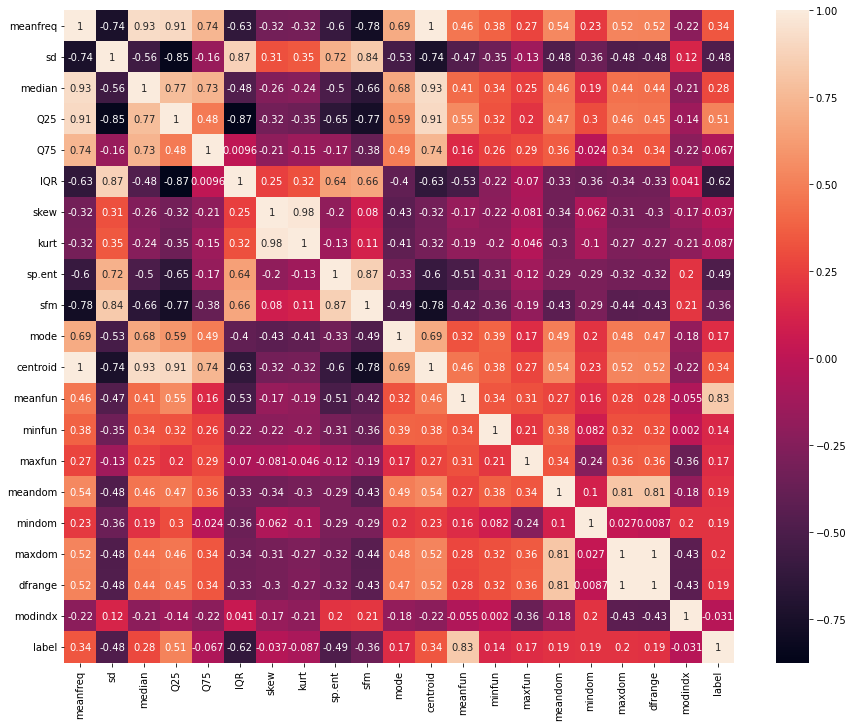

In [20]:
# Correlation between Features and Target:

plt.figure(figsize= (15,12))

sns.heatmap(data= df.corr(), annot= True)

plt.show()

<AxesSubplot:>

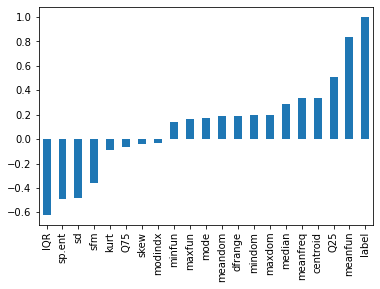

In [22]:
df.corr()["label"].sort_values().plot(kind= "bar")

### Train Test Split:

In [23]:
# Features:

x = df.drop("label", axis= 1)

In [24]:
x.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274


In [25]:
# Target:

y = df["label"]

In [26]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

In [28]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2534, 20)
(634, 20)
(2534,)
(634,)


### Scalling:

In [29]:
sc = StandardScaler()

In [30]:
temp = sc.fit_transform(x_train)
x_train = pd.DataFrame(temp, columns= x_train.columns)
x_train.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,-0.016393,-0.200347,0.103299,0.031212,-0.471361,-0.294220,-0.395860,-0.238770,0.513669,-0.073327,0.276075,-0.016393,-0.335977,0.528764,0.672890,0.252328,-0.464842,-0.258795,-0.250583,-0.384099
1,0.159693,0.475253,0.502570,0.932621,-0.047943,-1.089047,-0.099671,-0.191786,0.074571,0.384310,0.446923,0.159693,1.020206,0.592957,0.565932,0.458697,-0.464842,0.269624,0.278002,-0.733206
2,0.768417,-0.667889,0.445050,0.767694,0.638162,-0.524618,-0.213606,-0.197184,0.082487,-0.279575,0.164481,0.768417,0.826664,0.543286,0.513369,0.813255,-0.464842,0.982990,0.991593,-0.754531
3,-2.168469,1.437315,-2.302982,-2.088827,-1.332290,1.649179,-0.361213,-0.226098,1.497945,1.908397,-1.920162,-2.168469,1.800999,2.034552,-0.027515,-0.724255,-0.711738,-0.983169,-0.970781,0.644199
4,-0.032091,0.640981,-0.623959,-0.063808,0.947801,0.592806,-0.246804,-0.215448,0.830024,0.805191,-0.117566,-0.032091,-0.199469,-0.156518,0.629810,0.243590,-0.140789,-0.300903,-0.298486,0.735203


In [31]:
temp = sc.transform(x_test)
x_test = pd.DataFrame(temp, columns= x_test.columns)
x_test.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.199322,-1.775548,-0.038655,0.686193,-0.842262,-1.244111,-0.117770,-0.196557,-1.620726,-1.398101,0.199604,0.199322,0.925441,-0.700140,0.410026,-1.241920,-0.711738,-1.364072,-1.351803,-0.546672
1,0.267522,0.192024,0.270473,-0.046894,0.780246,0.481588,-0.390160,-0.237748,0.320385,-0.190721,-0.323878,0.267522,-0.310618,0.729144,0.461404,0.039291,-0.464842,1.029226,1.037844,-0.632348
2,-1.004769,1.798229,-0.315068,-1.444410,0.063548,1.680804,-0.129833,-0.108920,1.646668,2.104739,-1.496781,-1.004769,-1.029876,-1.025938,0.259318,0.767534,-0.711738,0.139721,0.152463,1.327359
3,0.093828,-0.988661,-0.088043,0.329184,-0.718612,-0.769441,-0.259181,-0.219525,0.070329,-0.530390,0.152732,0.093828,0.192089,-0.953407,0.113550,-0.538786,-0.711738,-0.463557,-0.451005,-0.063842
4,0.810137,-1.052387,0.691406,0.945899,0.183445,-0.977207,-0.248466,-0.218935,-0.420114,-0.767226,0.774843,0.810137,0.363296,0.533586,0.619102,1.406623,2.127575,1.617093,1.579644,-0.507127


### Support Vector Machine Using Grid Search:

In [32]:
model = SVC()

In [33]:
param_dict = {"kernel" : ["linear", "rbf", "poly"],
             "C" : [0.01, 0,1, 1, 10, 100],
             "degree" : [1,2,3], "gamma" : ["scale", "auto"]}

In [34]:
grid_model = GridSearchCV(estimator= model, param_grid= param_dict, cv= 5)

In [35]:
grid_model.fit(x_train, y_train)

C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py", line 226, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py", line 277, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 192, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shailya\AppData\Roaming\

C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py", line 226, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py", line 277, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 192, in sklearn.svm._libsvm.fit
ValueError: C <= 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Shailya\AppData\Roaming\

C:\Users\Shailya\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.97119302 0.88832316 0.89464103 0.97119302 0.88832316 0.89464103
 0.97119302 0.88832316 0.64126732 0.97119302 0.88832316 0.64245075
 0.97119302 0.88832316 0.8938435  0.97119302 0.88832316 0.89581589
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.97514091 0.9822454  0.97316775 0.97514091 0.98185015 0.97316775
 0.97514091 0.9822454  0.90134403 0.97514091 0.98185015 0.90134403
 0.97514091 0.9822454  0.9510622  0.97514091 0.98185015 0.9510622
 0.97514091 0.9822454  0.97316775 0.97514091 0.98185015 0.97316775
 0.97514091 0.9822454  0.90134403 0.97514091 0.98185015 0.90134403
 0.97514091 0.9822454  0.9510622  0.97514091 0.98185015 0.9510622
 0.9739567  0.97908569 0.97474644 0

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0, 1, 1, 10, 100], 'degree': [1, 2, 3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']})

In [36]:
grid_model.best_params_

{'C': 1, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [37]:
grid_model.best_estimator_

SVC(C=1, degree=1)

In [38]:
grid_model.best_score_

0.982245402312292

### Model Evaluation:

In [39]:
pred = grid_model.predict(x_test)

In [40]:
accuracy_score(y_test, pred)

0.9826498422712934

In [41]:
precision_score(y_test, pred)

0.9766666666666667

In [42]:
recall_score(y_test, pred)

0.9865319865319865

In [43]:
confusion_matrix(y_test, pred)

array([[330,   7],
       [  4, 293]], dtype=int64)

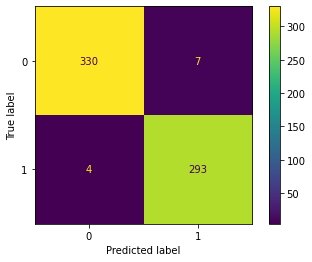

In [45]:
plot_confusion_matrix(grid_model, x_test, y_test)
plt.show()

In [46]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       337
           1       0.98      0.99      0.98       297

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634



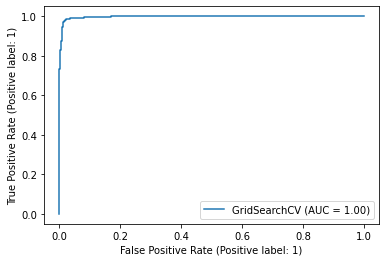

In [47]:
plot_roc_curve(grid_model, x_test, y_test)
plt.show()

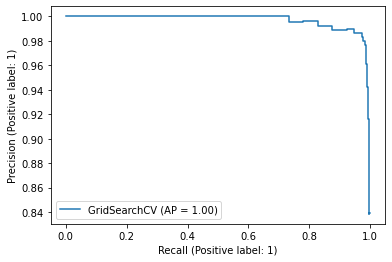

In [48]:
plot_precision_recall_curve(grid_model, x_test, y_test)
plt.show()